# 1.Імпорт і формування вибірки

In [30]:
import os
import PIL.Image
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def getImgs(path):
  imgs=[] 
  for img in os.listdir(path):
    imgs.append(np.array(PIL.Image.open(path+img)))
    
  return np.asarray(imgs)

imgs= getImgs('/content/drive/My Drive/mirflickr/')
print('Sampled {} RGB-images'.format(len(imgs)))

Sampled 250 RGB-images


In [0]:
green_img_list=[]
for img in imgs:
  green_img_list.append(np.array(cv2.split(img)[1]))

green_img_list = np.array(green_img_list)

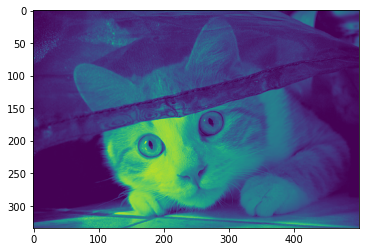

In [5]:
plt.imshow(green_img_list[8])

In [6]:
green_img_list[8].shape

(334, 500)

# 2.Декомпозиція

Для реалізації методу головних компонент застосувала бібліотеку sklearn. у функції нижче створюєтьс об'єкт PCA(), в якому важливим аргументом є n_components, що позначає відсоток або кількість головних компонент, які хочемо отримати (якщо None, тоді з документації n_components == min(n_samples, n_features) - 1, тобто в нашому випадку, декомпозуючи картинку, за кількість компонент вибирається або її ширина, або висота - залежно від того, що менше). Саму ж сингулярну декомпозицію забезпечує метод fit_transform(), який знаходить сингулярні вектори (вони ж - головні компоненти), відповідні їм сингулярні числа, дисперсія значень яскравості пікселів зеленого каналу і т.п. Для реконструкції зображення застосовуєтьс метод inverse_transform.

In [0]:
def decompose_reconstruct(img, reconstruct=False, alpha=None):
  pca = PCA(n_components=alpha, svd_solver='full')
  decomposed_img=pca.fit_transform(img)
  if reconstruct:
    return pca.inverse_transform(decomposed_img)
  return pca

Як приклад, реконструюємо одне із тестових зображень та побудуємо scree plot із першими 10-ма головними компонентами та відсотком дисперсії, яку кожна з них поснює.

In [0]:
pca=decompose_reconstruct(green_img_list[8])
reconstructed_img=decompose_reconstruct(green_img_list[8], reconstruct=True)

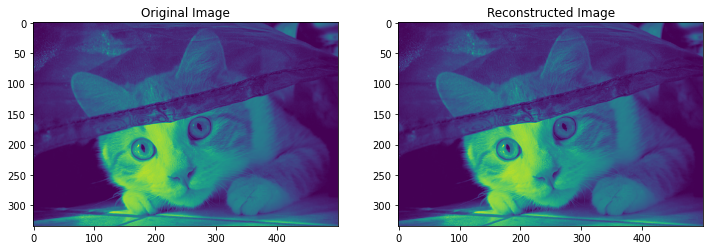

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 12))
axs[0].imshow(green_img_list[8])
axs[1].imshow(reconstructed_img)
axs[0].title.set_text('Original Image')
axs[1].title.set_text('Reconstructed Image')

Кількість компонент рівна висоті зображення.

In [10]:
len(pca.components_)==green_img_list[8].shape[0]

True

Scree plot

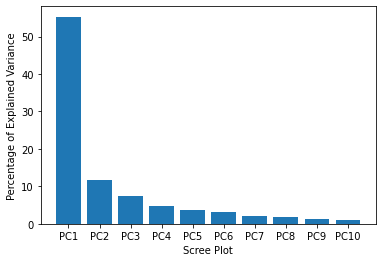

In [11]:
percentage_var=[]
for i in range(10):
  percentage_var.append(np.round(pca.explained_variance_ratio_[i]*100, decimals=1))
plot_labels = ['PC' + str(x) for x in range(1, 11)]
plt.bar(x=range(1, 11), height=percentage_var, tick_label = plot_labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Scree Plot')
plt.show()

a) За замовченням сингулярні числа вже відсортовані в порядку зменшення.

In [12]:
pca.singular_values_

array([1.32332115e+04, 6.09640528e+03, 4.83361279e+03, 3.89224375e+03,
       3.46375793e+03, 3.16874268e+03, 2.57378219e+03, 2.29363119e+03,
       2.01415216e+03, 1.66291265e+03, 1.53745826e+03, 1.45208564e+03,
       1.20783598e+03, 1.12320940e+03, 1.11792646e+03, 1.02242309e+03,
       9.73764463e+02, 9.46481741e+02, 8.92550359e+02, 8.49090562e+02,
       8.16026321e+02, 7.76080210e+02, 7.47266116e+02, 6.86093939e+02,
       6.40069550e+02, 6.31807824e+02, 5.88220281e+02, 5.71598766e+02,
       5.65358892e+02, 5.34144630e+02, 4.95912689e+02, 4.86615564e+02,
       4.75083071e+02, 4.68535141e+02, 4.54171247e+02, 4.30638118e+02,
       4.28778536e+02, 4.15230457e+02, 4.00283595e+02, 3.95959517e+02,
       3.84800378e+02, 3.82667238e+02, 3.69723955e+02, 3.56667271e+02,
       3.50669885e+02, 3.45014737e+02, 3.43138650e+02, 3.32706957e+02,
       3.30120518e+02, 3.22074427e+02, 3.19300926e+02, 3.11322994e+02,
       3.07262432e+02, 3.02966392e+02, 3.01814141e+02, 2.85878513e+02,
      

## Порівняння

In [13]:
mse_8 = mean_squared_error(green_img_list[8], reconstructed_img)
print('MSE={}'.format(mse_8))

MSE=2.1690441900678613e-26


Показник середньоквадратичного відхилення, обрахований вище, зовсім незначний, оскільки для реконструкції було використано всі головні компоненти. Виберемо лише alpha% компонент (10<alpha<100, step=10) і знову порівняємо вихідне та реконструйоване зображення за показником MSE. 

###b) Реконструкція зображенні при використанні alpha% компонентів

In [0]:
def reconstructed_list(img):
  reconstructed_list = [decompose_reconstruct(img, reconstruct=True, alpha=0.1*step) for step in range(1,10)]
  reconstructed_list.append(decompose_reconstruct(img, reconstruct=True))
  return np.array(reconstructed_list)

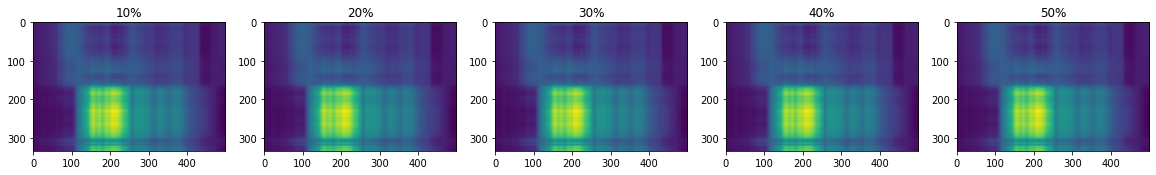

In [15]:
reconstructed_list_8 = reconstructed_list(green_img_list[8])
fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(reconstructed_list_8[0])
axs[0].title.set_text('10%')
axs[1].imshow(reconstructed_list_8[1])
axs[1].title.set_text('20%')
axs[2].imshow(reconstructed_list_8[2])
axs[2].title.set_text('30%')
axs[3].imshow(reconstructed_list_8[3])
axs[3].title.set_text('40%')
axs[4].imshow(reconstructed_list_8[4])
axs[4].title.set_text('50%')

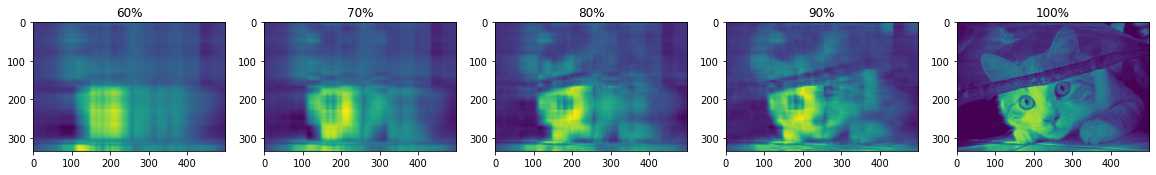

In [16]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(reconstructed_list_8[5])
axs[0].title.set_text('60%')
axs[1].imshow(reconstructed_list_8[6])
axs[1].title.set_text('70%')
axs[2].imshow(reconstructed_list_8[7])
axs[2].title.set_text('80%')
axs[3].imshow(reconstructed_list_8[8])
axs[3].title.set_text('90%')
axs[4].imshow(reconstructed_list_8[9])
axs[4].title.set_text('100%')

###c) Порівняння вихідного та реконструйованих зображень (MSE)

Функція нижче повертає масив із середньоквадратичних відхилень реконструйованого зображення від вихідного для кожного alpha (10-100%).

In [0]:
def compareImgs(original, images):
  mse_list = np.array([mean_squared_error(original, recon_img) for recon_img in images])
  return mse_list

In [0]:
alphas = [10*step for step in range(1, 11)]

In [0]:
mse_list = compareImgs(green_img_list[8], reconstructed_list_8)

In [20]:
df = pd.DataFrame(data=mse_list, columns=['MSE'], index=["{}{}".format(a, '%') for a in alphas])
df.T

,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
MSE,848.031981,848.031981,848.031981,848.031981,848.031981,625.480141,485.577072,323.019105,167.433249,2.169044e-26


Графік залежності значення середньоквадратичного відхилення від частки головних компонент, що була використана для реконструкції зображення.

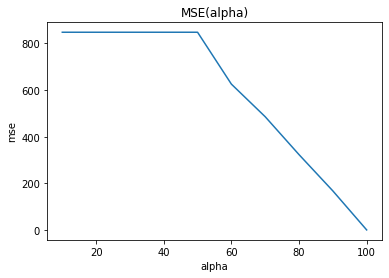

In [21]:
plt.plot(alphas, mse_list)
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('MSE(alpha)')
plt.show()

###d) Усереднині MSE(alpha) по тестовому пакету

In [0]:
def mean_mse(original_imgs, rcnstrctd_imgs):
  mean_mse = [np.mean([mean_squared_error(original_imgs[idx], rcnstrctd_imgs[alpha][idx]) for idx in range(len(original_imgs))]) for alpha in range(10)]
  return mean_mse

In [0]:
rcnstrctd_list_alphas = [[decompose_reconstruct(img, reconstruct=True, alpha=0.1*step) for img in green_img_list] for step in range(1,10)]
rcnstrctd_list_alphas.append([decompose_reconstruct(img, reconstruct=True) for img in green_img_list])
rcnstrctd_list_alphas = np.array(rcnstrctd_list_alphas)

In [0]:
mean_mse = mean_mse(green_img_list, rcnstrctd_list_alphas)

In [25]:
df = pd.DataFrame(data=mean_mse, columns=['Mean MSE'], index=["{}{}".format(a, '%') for a in alphas])
df.T

,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
Mean MSE,1697.948712,1682.171739,1597.620534,1444.325154,1267.735455,1081.515872,852.842967,591.520586,307.047362,4.798322e-26


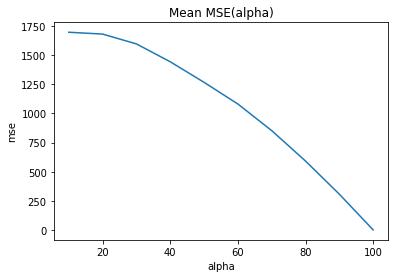

In [26]:
plt.plot(alphas, mean_mse)
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Mean MSE(alpha)')
plt.show()

# Моделювання марківськими ланцюгами

##a) Формування стохастичної матриці

Всього станів у марківському ланцюзі 256 (кожний відповідає за значення яскравості пікселя), тому утворена матриця має розмір (256, 256) і містить імовірності переходу від одного стану до іншого. До нормалізації матриця формувалася обробкою значень яскравості пікселів методом 2 (по горизонталі, справа наліво). 

In [0]:
def right_to_left_iteration(img, matrix):
  for row in range(img.shape[0]):
    for col in range(img.shape[1]-1, 0, -1):
      from_idx, to_idx = img[row][col], img[row][col-1]
      matrix[from_idx][to_idx]+=1

#https://stackoverflow.com/questions/8904694/how-to-normalize-a-2-dimensional-numpy-array-in-python-less-verbose
def normalize(matrix):
  row_sums = matrix.sum(axis=1) #сумуємо вздовж рядка по значеннях у стовпцях; на виході - масив із сумами кожного рядка
  return matrix/row_sums[:, np.newaxis] #row_sums.shape=(256,) -> row_sums.shape = (256, 1): для коректного ділення матриці на масив

def stochastic_matrix(images):
  st_mtrx = np.zeros((256, 256))
  for img in images:
    right_to_left_iteration(img, st_mtrx)
  st_mtrx = normalize(st_mtrx)
  return st_mtrx

In [28]:
Q = stochastic_matrix(green_img_list)
Q.shape

(256, 256)

##b) Графічне представлення марківського ланцюга його перехідною матрицею

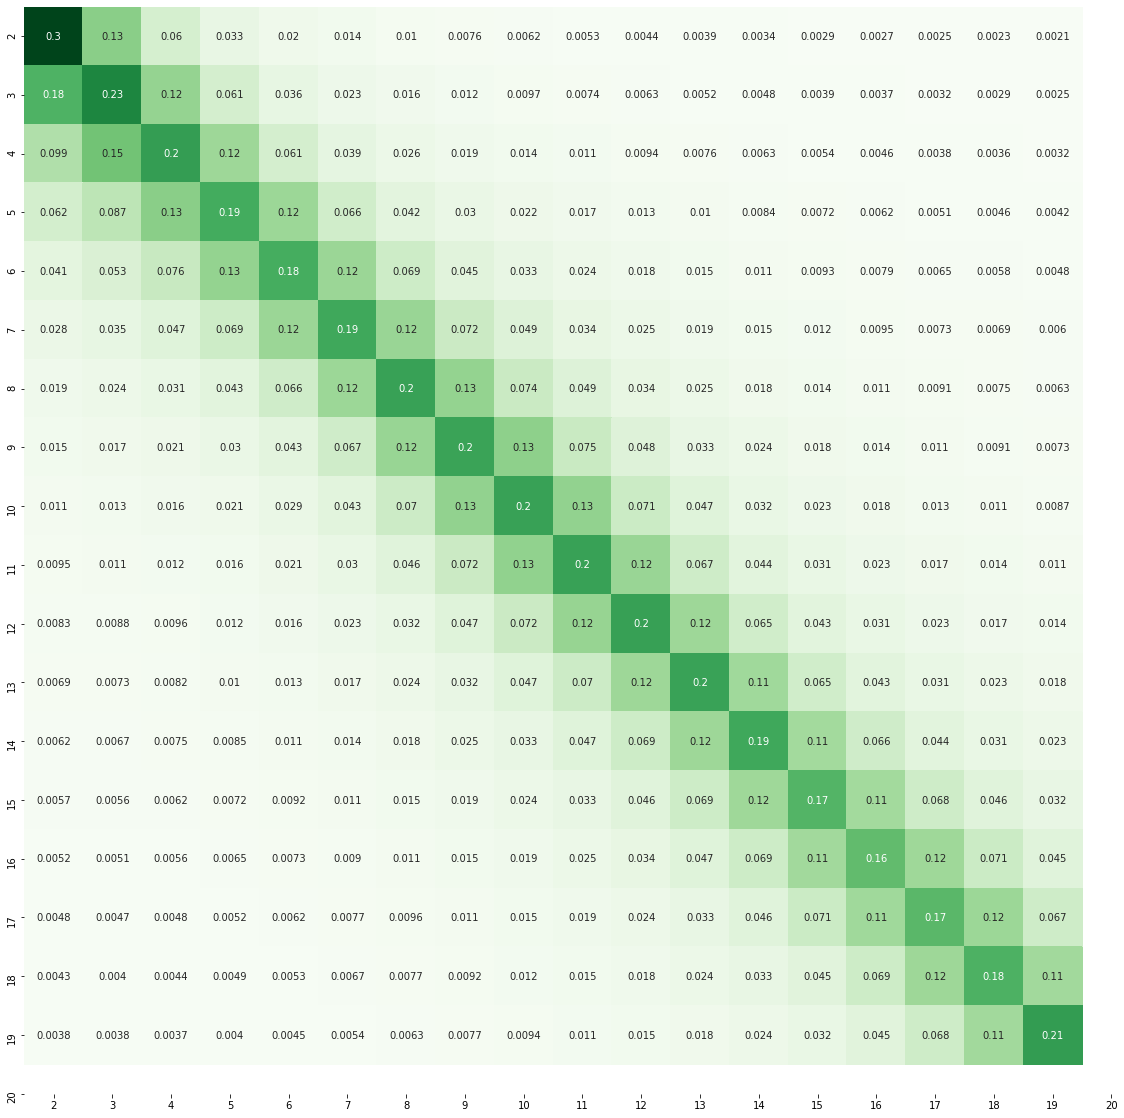

In [35]:
plt.figure(figsize=(20,20))
sns.heatmap(Q[2:20, 2:20], square=True,cbar=False,cmap='Greens',annot=True,xticklabels=[i for i in range(2,21)],yticklabels=[i for i in range(2,21)])
plt.show();

##c) Перевірка регулярності та рекурентності

Марківський ланцюг є *регулярним*, якщо його матриця переходів є регулярною. Матриця переходів є регулярною, якщо деякий її степінь містить лише додатні елементи.

Марківський ланцюг є *рекурентним*, якщо кожен його стан рекурентний, тобто вийшовши з деякого стану, ми колись до нього повернемося. Це можна перевірити за матрицею переходу: на певному кроці (в нашому випадку - на 5) її діагональні елементи мають бути ненульовими.

In [0]:
def is_regular(mtrx):
  return np.all(mtrx>0)

def is_reccurent(mtrx):
  for state in range(mtrx.shape[0]):
    if mtrx[state][state]==0:
      return False
  return True

In [46]:
Q_5 = np.linalg.matrix_power(Q, 5)
if is_regular(Q_5):
  print('Матриця переходу є регулярною.')
else:
  print('Матриця переходу не є регулярною.')
if is_reccurent(Q_5):
  print('Матриця переходу є рекурентною.')
else:
  print('Матриця переходу не є рекурентною.')

Матриця переходу є регулярною.
Матриця переходу є рекурентною.
